In [ ]:
import pandas as pd
import numpy as np
import pickle
from sklearn.metrics import confusion_matrix, multilabel_confusion_matrix
from sklearn.metrics import classification_report
import matplotlib.pyplot as plt
import seaborn as sns

In [ ]:
# Load pickle file with results
with open('results.pkl', 'rb') as f:
    results = pickle.load(f)

cm = {}
fi = {}
roc = {}


# Print the results
for dataset, models in results.items():
    print(f"Dataset: {dataset}")
    approach = dataset.split('_')[0]
    dataset_name = "_".join(dataset.split('_')[1:])
    X_test = pd.read_csv(f"./datasets/preprocessed/{approach}/{dataset_name}/X_test.csv")
    y_test = pd.read_csv(f"./datasets/preprocessed/{approach}/{dataset_name}/y_test.csv")

    for model_name, model_results in models.items():
        print(f"  Model: {model_name}")
        y_pred = model_results['fitted_model'].predict(X_test)
        
        # Confusion matrix
        cm[(dataset,model_name)] = confusion_matrix(y_test, y_pred)
        

        # Feature importance
        if hasattr(model_results['fitted_model'], 'feature_importances_'):
                fi[(dataset,model_name)] = pd.DataFrame({
                    'Feature': X_test.columns,
                    'Importance': model_results['fitted_model'].feature_importances_
                }).sort_values(by='Importance', ascending=False)
        elif hasattr(model_results['fitted_model'], 'coef_'):
            fi[(dataset,model_name)] = pd.DataFrame({
                'Feature': X_test.columns,
                'Importance': np.abs(model_results['fitted_model'].coef_[0])
            }).sort_values(by='Importance', ascending=False)
        else:
            fi[(dataset, model_name)] = None


In [ ]:
# Plot confusion matrices
for (dataset, model_name), cm_df in cm.items():
    plt.figure(figsize=(10, 7))
    sns.heatmap(cm_df, annot=True, fmt='d', cmap='Blues')
    plt.title(f"Confusion Matrix for {model_name} on {dataset}")
    plt.xlabel('Predicted')
    plt.ylabel('Actual')
    plt.show()


In [ ]:
# Feature importance plots
# Plot the feature importances
for (dataset, model_name), fi_df in fi.items():
    if fi_df is not None:
        plt.figure(figsize=(10, 7))
        sns.barplot(x='Importance', y='Feature', data=fi_df.head(10))
        plt.title(f"Feature Importances for {model_name} on {dataset}")
        plt.xlabel('Importance')
        plt.ylabel('Feature')
        plt.show()

In [ ]:
# Classification report
for dataset, models in results.items():
    print(f"Dataset: {dataset}")
    for model_name, model_results in models.items():
        y_pred = model_results['fitted_model'].predict(X_test)
        print(f"  Model: {model_name}")
        print(classification_report(y_test, y_pred, zero_division=0))
        print("\n")

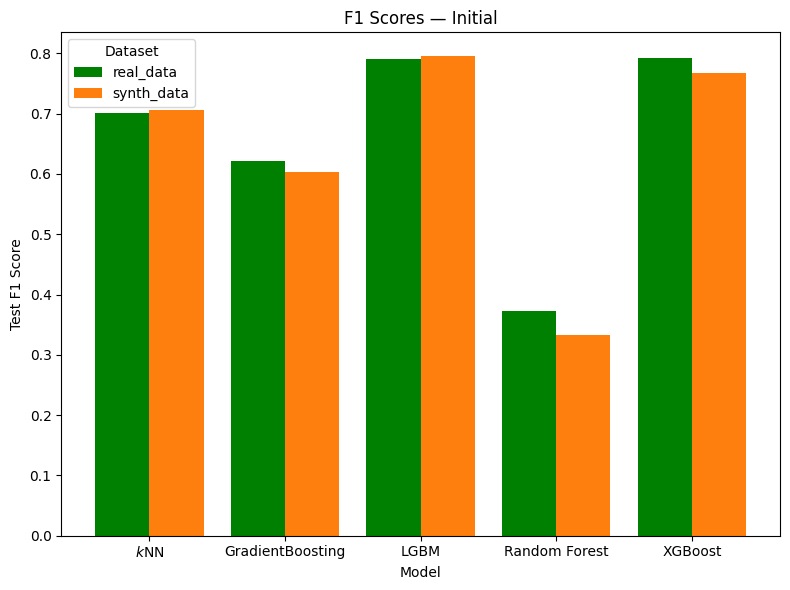

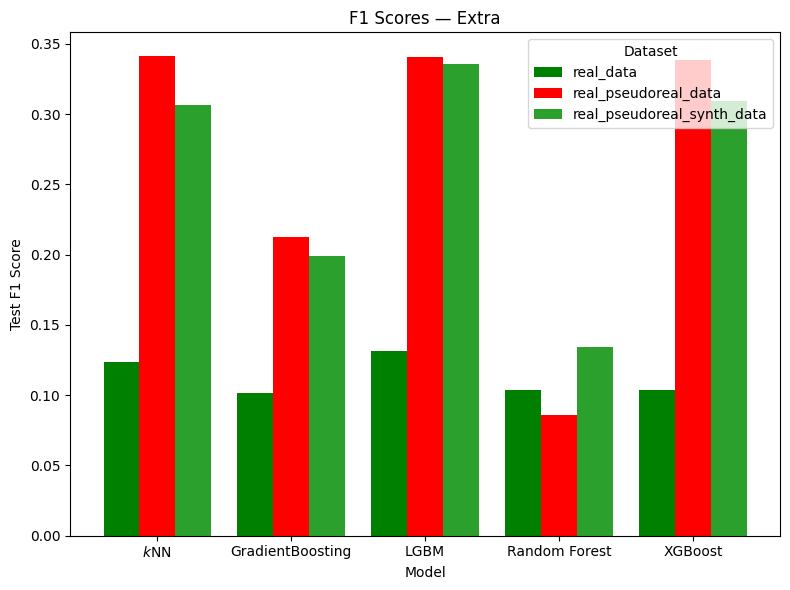

In [5]:

# 1) Flatten into a DataFrame
records = []
for dataset, models in results.items():
    for model, metrics in models.items():
        approach = dataset.split('_')[0]
        dataset_name = "_".join(dataset.split('_')[1:])
        records.append({
            'approach': approach,
            'dataset': dataset_name,
            'model': model,
            'f1': metrics['test_f1']
        })

df = pd.DataFrame.from_records(records)

# 2) Define the explicit color map for known datasets
color_map = {
    'real_data': 'green',
    'real_pseudoreal_data': 'red',
    # add other explicit mappings here…
}

# 3) Plotting helper
def plot_approach(df, approach_name):
    sub = df[df['approach'] == approach_name]
    pivot = sub.pivot(index='model', columns='dataset', values='f1')
    
    # Build a colors list, falling back to the default cycle
    default_cycle = plt.rcParams['axes.prop_cycle'].by_key()['color']
    default_iter = iter(default_cycle)
    colors = [
        color_map.get(ds, next(default_iter))
        for ds in pivot.columns
    ]
    
    ax = pivot.plot(
        kind='bar',
        figsize=(8, 6),
        width=0.8,
        color=colors
    )
    ax.set_title(f'F1 Scores — {approach_name}')
    ax.set_ylabel('Test F1 Score')
    ax.set_xlabel('Model')
    ax.legend(title='Dataset')
    plt.xticks(rotation=0)
    plt.tight_layout()
    plt.show()

# 4) Draw both charts
plot_approach(df, 'Initial')
plot_approach(df, 'Extra')
